In [1]:
### Question 5 ~ Comparisions among Brands on Supports

In [2]:
import tweepy
from tweepy import OAuthHandler
import json
import csv
from tweepy import Cursor
import pandas as pd
import datetime
from datetime import timedelta
import time
import csv
import networkx as nx
from operator import itemgetter
import community #This is the python-louvain package we installed.
import matplotlib.pyplot as plt

In [3]:
# load/read from file using JSON
secrets = json.loads(open("secrets_Apple.json","r").read())

consumer_key = secrets['CONSUMER_KEY']
consumer_secret = secrets['CONSUMER_SECRET']
access_token = secrets['ACCESS_TOKEN_KEY']
access_token_secret = secrets['ACCESS_TOKEN_SECRET']


auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth, wait_on_rate_limit=True,wait_on_rate_limit_notify=True)

#change per brand
screen_name = "AppleSupport"


In [4]:
def initialize():
    auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    api = tweepy.API(auth, parser = tweepy.parsers.JSONParser())
    return api
api = initialize()

In [5]:
comp_searches = ("@AppleSupport", "@SamsungSupport", "@Moto_Support", "@XiaomiSupport" )

In [6]:
# Array to hold sentiment
sentiments = []
# Iterate through all the comp_searches
for search in comp_searches:
       
    # Bring out the 100 tweets
    comp_tweets = api.user_timeline(search, count=10000)
    
    # Loop through the 100 tweets
    for tweet in comp_tweets:
        text = tweet["text"]
        
     # Add each value to the appropriate array
        sentiments.append({"User": search,
                           "text":text,
                       "Date": tweet["created_at"] 
                        })

In [7]:
#convert array to dataframe
import pandas as pd
import numpy as np

df = pd.DataFrame.from_dict(sentiments)
df.head(5)

,User,text,Date
0,@AppleSupport,@jwezzyyy Thanks for reaching out. We can cert...,Thu Mar 11 17:37:57 +0000 2021
1,@AppleSupport,@RobertInNJ Thanks for reaching out. We can he...,Thu Mar 11 17:20:08 +0000 2021
2,@AppleSupport,@pewpy Thanks for reaching out. We can help ge...,Thu Mar 11 17:11:54 +0000 2021
3,@AppleSupport,@anjlijayaram Hey there! Thanks for connecting...,Thu Mar 11 17:06:54 +0000 2021
4,@AppleSupport,@gitunyeee Thanks for reaching out to us about...,Thu Mar 11 17:06:39 +0000 2021


In [8]:
#to see tweets for specific User name 
df_samsung = df[ df['User'] == '@SamsungSupport']
df_samsung.head()

,User,text,Date
200,@SamsungSupport,@JAYBO1951 Hey there! Welcome to our support c...,Thu Mar 11 17:40:09 +0000 2021
201,@SamsungSupport,"@BurkeLyon Hello, there! Welcome to the US Sam...",Thu Mar 11 17:37:44 +0000 2021
202,@SamsungSupport,@ohitssotrue Hello there! Welcome to our Socia...,Thu Mar 11 17:03:58 +0000 2021
203,@SamsungSupport,@timetravelersl2 Hello! I'm passing by to know...,Thu Mar 11 16:55:12 +0000 2021
204,@SamsungSupport,"@AreUFromHere Hi, Sharif! Welcome to our Samsu...",Thu Mar 11 16:42:56 +0000 2021


In [9]:
#cleaning the tweets
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i, '', input_txt)        
    return input_txt
def clean_tweets(tweets):
    #remove twitter Return handles (RT @xxx:)
    tweets = np.vectorize(remove_pattern)(tweets, "RT @[\w]*:") 
    
    #remove twitter handles (@xxx)
    tweets = np.vectorize(remove_pattern)(tweets, "@[\w]*")
    
    #remove URL links (httpxxx)
    tweets = np.vectorize(remove_pattern)(tweets, "https?://[A-Za-z0-9./]*")
    
    #remove special characters, numbers, punctuations (except for #)
    tweets = np.core.defchararray.replace(tweets, "[^a-zA-Z]", " ")
    
    return tweets

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import tweepy
import re

df['text'] = clean_tweets(df['text'])
df['text'].head()

0     Thanks for reaching out. We can certainly hel...
1     Thanks for reaching out. We can help point yo...
2     Thanks for reaching out. We can help get you ...
3     Hey there! Thanks for connecting with us toda...
4     Thanks for reaching out to us about this, we ...
Name: text, dtype: object

In [11]:
# pip install vaderSentiment

In [12]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
analyzer = SentimentIntensityAnalyzer()

In [13]:
scores = []
# Declare variables for scores
compound_list = []
positive_list = []
negative_list = []
neutral_list = []
for i in range(df['text'].shape[0]):
#print(analyser.polarity_scores(sentiments_pd['text'][i]))
    compound = analyzer.polarity_scores(df['text'][i])["compound"]
    pos = analyzer.polarity_scores(df['text'][i])["pos"]
    neu = analyzer.polarity_scores(df['text'][i])["neu"]
    neg = analyzer.polarity_scores(df['text'][i])["neg"]
    
    scores.append({"Compound": compound,
                       "Positive": pos,
                       "Negative": neg,
                       "Neutral": neu
                  })

In [14]:
sentiments_score = pd.DataFrame.from_dict(scores)
df = df.join(sentiments_score)
df.head()

,User,text,Date,Compound,Positive,Negative,Neutral
0,@AppleSupport,Thanks for reaching out. We can certainly hel...,Thu Mar 11 17:37:57 +0000 2021,0.8439,0.387,0.0,0.613
1,@AppleSupport,Thanks for reaching out. We can help point yo...,Thu Mar 11 17:20:08 +0000 2021,0.7579,0.347,0.0,0.653
2,@AppleSupport,Thanks for reaching out. We can help get you ...,Thu Mar 11 17:11:54 +0000 2021,0.7506,0.330,0.0,0.670
3,@AppleSupport,Hey there! Thanks for connecting with us toda...,Thu Mar 11 17:06:54 +0000 2021,0.8622,0.375,0.0,0.625
4,@AppleSupport,"Thanks for reaching out to us about this, we ...",Thu Mar 11 17:06:39 +0000 2021,0.7717,0.314,0.0,0.686


In [15]:
HT_positive = []
def hashtag_extract(x):
    hashtags = []
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r"#(\w+)", i)
        hashtags.append(ht)
    return hashtags
# extracting hashtags from positive tweetsHT_positive = hashtag_extract(df_tws['text'][df_tws['sent'] == 1])
# extracting hashtags from  tweets
HT_positive = hashtag_extract(df['text'][df['Compound'] > 0.5])
# unnesting list
HT_positive = sum(HT_positive,[])
HT_positive

['GalaxyS21',
 'HelloMiFans',
 'HelloMiFans',
 'XiaomiSupportTips',
 'MiQuiz',
 'HelloMiFans',
 'HelloMiFans',
 'Miquiz',
 'HelloMiFans',
 '64663',
 'MiFans',
 'XiaomiSupport',
 'NoMiWithoutYou']

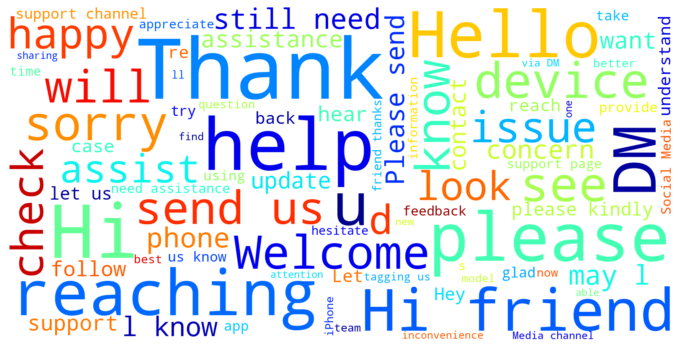

In [16]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
def word_cloud(wd_list):
    stopwords = set(STOPWORDS)
    all_words = ' '.join([text for text in wd_list])
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        width=1600,
        height=800,
        random_state=1,
        colormap='jet',
        max_words=80,
        max_font_size=200).generate(all_words)
    plt.figure(figsize=(12, 10))
    plt.axis('off')
    plt.imshow(wordcloud, interpolation="bilinear");
word_cloud(df['text'])

In [17]:
#Collect the compound values for each news source
score_table = df.pivot_table(index='User',  values="Compound", aggfunc = np.mean)
score_table

,Compound
User,
@AppleSupport,0.585950
@Moto_Support,0.442603
@SamsungSupport,0.584259
@XiaomiSupport,0.532108


In [18]:
score_table2 = df.pivot_table(index='User',  values="Negative", aggfunc = np.mean)
score_table2 

,Negative
User,
@AppleSupport,0.006435
@Moto_Support,0.025945
@SamsungSupport,0.020040
@XiaomiSupport,0.024365


In [19]:
score_table2.to_csv('blue.csv')

In [20]:
score_table3 = df.pivot_table(index='User',  values="Positive", aggfunc = np.mean)
score_table3

,Positive
User,
@AppleSupport,0.251700
@Moto_Support,0.198745
@SamsungSupport,0.260830
@XiaomiSupport,0.279185


In [21]:
score_table3.to_csv('yellow.csv')

In [22]:
score_table4 = df.pivot_table(index='User',  values="Neutral", aggfunc = np.mean)
score_table4

,Neutral
User,
@AppleSupport,0.741870
@Moto_Support,0.770330
@SamsungSupport,0.719145
@XiaomiSupport,0.696440


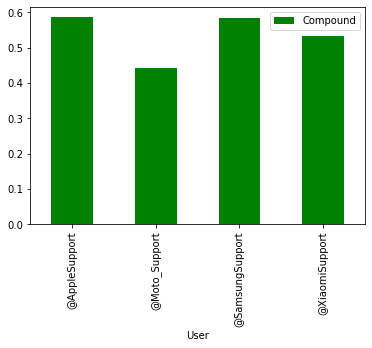

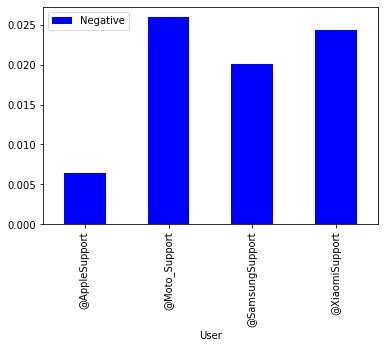

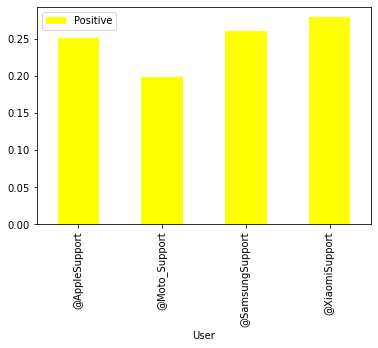

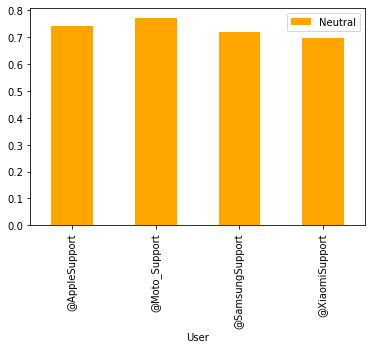

In [23]:
#plotting 
g = score_table.plot(kind='bar',color="Green")
g2 =score_table2.plot(kind='bar',color="Blue")
g3 =score_table3.plot(kind='bar',color="Yellow")
g4 =score_table4.plot(kind='bar',color="Orange")
